# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2  
%autosave 10

Autosaving every 10 seconds


In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from PIL import Image
import random, os, sys, argparse
from pathlib import Path
from tqdm import tqdm
import pickle

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap

In [3]:
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/scripts/')
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/scripts/toy_models/')
from models import *
from toy_models import *

# User Hyperparams

In [4]:
model = 'vgg16' # resnet18, vgg16, densenet121, mlp
dataset = 'kmnist' # mnist,kmnist, fmnist, svhn, cifar10
add_patch_flag = True # adds a random white patch at a class-specific location
save_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/output' # directory to save output
data_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/' # directory which has data; or where you want to download data if missing

num_pd_imgs = 100 # no. of pd imgs to plot from test data
num_epochs = 5
lr = 0.1
seed = 0
num_ch = 1 # num of channels in image
num_embs = 1000 # (number of embeddings) training data size for KNN used in PD
K = 29 # k neighbours in k-NN
num_test_imgs = 50 # num of test images for plotting PD
lp_norm = 1 # for computing KNN
knn_pos_thresh = 0.5 # k-NN output above this value treated as positive
knn_neg_thresh = 0.5 # k-NN output below this value treated as negative; intermediate values treated as undefined PD samples
expt_name = f'{model}_{dataset}_{int(random.random()*100000)}' # characteristic name for the experiment (used for saving)

# Util Functions

In [5]:
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Load Dataset

In [6]:
# Setting the seed
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# datasets
print('==> Preparing data..')
if dataset=='mnist':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
            ])  
    trainset = torchvision.datasets.MNIST(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.MNIST(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
elif dataset=='fmnist':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
            ])  
    trainset = torchvision.datasets.FashionMNIST(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.FashionMNIST(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
elif dataset=='kmnist':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
            ]) 
    trainset = torchvision.datasets.KMNIST(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.KMNIST(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=True, num_workers=2)
    
elif dataset=='svhn':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
            ])  
    trainset = torchvision.datasets.SVHN(data_dir, split='train', transform=trans, download=True)
    testset = torchvision.datasets.SVHN(data_dir, split='test', transform=trans, download=True)
    trainset.targets = trainset.labels
    testset.targets = testset.labels
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
elif dataset=='cifar10':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=0.4914,std=0.2470)
            ])  
    trainset = torchvision.datasets.CIFAR10(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.CIFAR10(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

==> Preparing data..


In [8]:
dir(trainset.data)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '

In [9]:
# add spurious-white patch
def add_patch(img,lab):
    mid = img.shape[0]//2
    mid_x = mid-2
    mid_y = mid+3    
    if lab==0:
        img[:4,:4] = 255
    elif lab==1:
        img[:4,-4:] = 255
    elif lab==2:
        img[-4:,:4] = 255
    elif lab==3:
        img[-4:,-4:] = 255
    elif lab==4:
        img[mid_x:mid_y,mid_x:mid_y] = 255
    elif lab==5: 
        img[:4,12:16] = 255
    elif lab==6:  
        img[-4:,12:16] = 255
    elif lab==7:
        img[12:16,:4] = 255
    elif lab==8:    
        img[12:16,-4:] = 255        
    return img

if add_patch_flag:    
    for (img,lab) in zip(trainset.data,trainset.targets):
        img = add_patch(img,lab)        
    for (img,lab) in zip(testset.data,testset.targets):
        img = add_patch(img,lab)

# Train Model

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

# Model
print('==> Building model..')
if model=='resnet18':
    net = ResNet18(num_channels=num_ch)
elif model=='vgg16':
    net = VGG('VGG16',num_channels=num_ch)
elif model=='densenet121':
    net = DenseNet121()
elif model=='mlp':
    net = nn.Sequential(torch.nn.Linear(1024, 10))
net = net.to(device)
    
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if model=='mlp':
            outputs = net(inputs.reshape((inputs.shape[0],-1)))
        else:
            outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if model=='mlp':
                outputs = net(inputs.reshape((inputs.shape[0],-1)))
            else:
                outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))
        best_acc = acc


for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Building model..

Epoch: 0


100%|██████████| 469/469 [00:17<00:00, 27.22it/s]


468 469 Loss: 1.621 | Acc: 45.418% (27251/60000)


100%|██████████| 20/20 [00:01<00:00, 16.55it/s]


19 20 Loss: 0.432 | Acc: 82.460% (8246/10000)
Saving..

Epoch: 1


100%|██████████| 469/469 [00:09<00:00, 48.63it/s]


468 469 Loss: 0.037 | Acc: 98.997% (59398/60000)


100%|██████████| 20/20 [00:00<00:00, 23.12it/s]


19 20 Loss: 0.007 | Acc: 99.870% (9987/10000)
Saving..

Epoch: 2


100%|██████████| 469/469 [00:09<00:00, 49.31it/s]


468 469 Loss: 0.006 | Acc: 99.852% (59911/60000)


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


19 20 Loss: 0.038 | Acc: 98.970% (9897/10000)

Epoch: 3


100%|██████████| 469/469 [00:09<00:00, 49.27it/s]


468 469 Loss: 0.004 | Acc: 99.918% (59951/60000)


100%|██████████| 20/20 [00:00<00:00, 23.69it/s]


19 20 Loss: 0.005 | Acc: 99.940% (9994/10000)
Saving..

Epoch: 4


100%|██████████| 469/469 [00:09<00:00, 48.65it/s]


468 469 Loss: 0.003 | Acc: 99.933% (59960/60000)


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


19 20 Loss: 0.001 | Acc: 99.990% (9999/10000)
Saving..


# Obtain Train (subset) embeddings

In [11]:
## code for loading checkpoint [in case you want to load a different pre-trained model]
# expt_name = 'vgg16_cifar10_29954'
# if model=='resnet18':
#     net = nn.DataParallel(ResNet18(num_channels=num_ch))
# elif model=='vgg16':
#     net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()

In [12]:
# add hooks to intermediate layers to collect feature embeddings
def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net

In [13]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out): # the hook function used to collect features at intermediate layers
    out = torch.nn.functional.interpolate(out,(8,8)) # reduce dimensions for easy PD computation
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)

In [14]:
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [15]:
labs = torch.tensor(trainset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_embs]
labs = labs[inds]
samples = torch.tensor(trainset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs) 
elif dataset=='cifar10':
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img.permute(2,0,1)))))
    samples_resized = samples_resized.unsqueeze(1)
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs)  
elif dataset=='svhn':
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    samples_resized = samples_resized.unsqueeze(1)
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs) 
else:
    train_subset = torch.utils.data.TensorDataset(samples,labs)
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

In [16]:
img.shape

torch.Size([28, 28])

In [17]:
samples_resized.shape

torch.Size([1000, 32, 32])

In [18]:
# code for saving pkl file of layer embeddings
save_path = os.path.join(save_dir,f'{expt_name}.pkl')
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=30000, shuffle=True, num_workers=2)

handle = open(save_path, "wb")

with torch.no_grad():
    net.eval()
    for b_idx,batch in enumerate(tqdm(trainloader2)):        
        # print GPU memory
        print_memory_profile('Initial')
        
        if dataset=='mnist'  or dataset=='kmnist' or dataset=='fmnist':
            imgs = batch[0].unsqueeze(1).to('cuda')
        elif dataset=='svhn' or dataset=='cifar10':
            imgs = batch[0].to('cuda')
        else:
            imgs = batch[0].permute(0,3,1,2).to('cuda')
        labels = batch[1]
        
        feature_maps = []
        out = net(imgs.float())
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(trainloader2),'feats':feature_maps,'labels':labels}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        

  0%|          | 0/1 [00:00<?, ?it/s]

Initial
31.7391357421875 5.06640625 0.16744089126586914




100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

After processing Batch
31.7391357421875 7.130859375 1.1789531707763672


After freeing GPU memory
31.7391357421875 1.91796875 0.1718730926513672




# Compute PD

In [19]:
# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

In [20]:
labs = torch.tensor(testset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_test_imgs]
labs = labs[inds]
samples = torch.tensor(testset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
else:
    test_subset = torch.utils.data.TensorDataset(samples,labs)
testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

In [21]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
ckpt_path = os.path.join(save_dir,f'{expt_name}.pt')
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['pred_probs'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
31.7391357421875 1.91796875 0.1718730926513672




In [22]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
for test_id, (img,lab) in enumerate(tqdm(testset)):
    if test_id==num_pd_imgs:
        break
    img = img.permute([1,2,0])
    batch_info['imgs'].append(img)
    with torch.no_grad():
        to_pil_trans = transforms.ToPILImage()
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        lab = int(lab)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (feats_dimensionality, num_imgs) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (feats_dimensionality, num_imgs) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')

  0%|          | 0/10000 [00:00<?, ?it/s]

OUT = tensor([[-5.6184, -3.0481,  9.7036, -1.5518,  1.8000,  1.1613,  1.5996, -5.1149,
         -0.2628,  1.4856]], device='cuda:0')
Model output: 9.703640937805176
Model forward pass
31.7391357421875 1.919921875 0.17284297943115234


Pickle load
31.7391357421875 1.919921875 1.1799230575561523





0it [00:00, ?it/s]
13it [00:00, 25.54it/s][A
  0%|          | 1/10000 [00:02<6:48:35,  2.45s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 0
knn_preds_mode: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.4482758641242981, 0.4482758641242981, 0.6896551847457886, 0.5862069129943848, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 2
pred: 2


OUT = tensor([[ 0.6434, -3.9591, -0.5217, -3.0574,  1.3376,  0.9801, -1.1401,  0.5926,
         -4.2478,  9.4439]], device='cuda:0')
Model output: 9.443881034851074
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.25it/s]
  0%|          | 2/10000 [00:03<4:37:08,  1.66s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 1
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.517241358757019, 0.5517241358757019, 0.6206896305084229, 0.6551724076271057, 0.8620689511299133, 0.6206896305084229, 0.6551724076271057, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ -8.1838, -12.5487,  -2.4320,  12.7620,   1.1787,   4.0997,   1.6108,
           2.8492,  -0.3445,   1.1738]], device='cuda:0')
Model output: 12.76201057434082
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1526.53it/s]
  0%|          | 3/10000 [00:04<3:53:28,  1.40s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 2
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.4137931168079376, 0.517241358757019, 0.8965517282485962, 0.7931034564971924, 1.0, 0.931034505367279, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-3.4402,  1.5337, -1.3988,  0.6800, -1.1558, -2.9422,  0.5849, -1.5446,
          9.6911, -1.6759]], device='cuda:0')
Model output: 9.691093444824219
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1526.44it/s]
  0%|          | 4/10000 [00:05<3:33:50,  1.28s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 3
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.4137931168079376, 0.4482758641242981, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[ -5.8252, -11.5322,  -1.5184,  10.6814,   2.9595,   4.0530,   0.9054,
           2.2860,  -4.2314,   2.3018]], device='cuda:0')
Model output: 10.681355476379395
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.82it/s]
  0%|          | 5/10000 [00:06<3:22:07,  1.21s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 4
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.9655172228813171, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ -7.4463, -12.2144,  -1.9672,  12.2431,   2.0196,   3.8394,   1.4150,
           2.2626,  -1.7664,   1.7346]], device='cuda:0')
Model output: 12.243091583251953
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1572.12it/s]
  0%|          | 6/10000 [00:07<3:14:50,  1.17s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 5
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6206896305084229, 0.6551724076271057, 1.0, 1.0, 0.931034505367279, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-3.5049,  1.2620, -1.5204,  0.7717, -1.2188, -2.8218,  0.6673, -1.3189,
          9.6122, -1.6004]], device='cuda:0')
Model output: 9.6122407913208
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1521.29it/s]
  0%|          | 7/10000 [00:09<3:10:20,  1.14s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 6
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.6551724076271057, 0.6896551847457886, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[ -7.3649, -11.3071,  -2.0982,  11.6176,   1.6224,   3.5414,   1.2641,
           2.3739,  -0.8479,   1.3189]], device='cuda:0')
Model output: 11.617584228515625
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1520.52it/s]
  0%|          | 8/10000 [00:10<3:07:24,  1.13s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 7
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.517241358757019, 0.37931033968925476, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 0.8620689511299133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-5.6573, -3.0565, 10.0118, -1.6411,  1.7375,  1.3875,  1.4747, -5.2890,
         -0.4368,  1.6253]], device='cuda:0')
Model output: 10.011832237243652
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.99it/s]
  0%|          | 9/10000 [00:11<3:05:28,  1.11s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 8
knn_preds_mode: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.6206896305084229, 0.5517241358757019, 0.7931034564971924, 0.7586206793785095, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 2
pred: 2


OUT = tensor([[-4.7683, -8.8336,  1.4464,  2.7472, -1.7615,  9.6283,  0.3720,  1.1849,
         -2.5606,  2.8042]], device='cuda:0')
Model output: 9.628270149230957
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.86it/s]
  0%|          | 10/10000 [00:12<3:04:08,  1.11s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 9
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.517241358757019, 0.517241358757019, 0.7931034564971924, 0.7241379022598267, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-6.3661, -9.5553,  1.1257,  0.4634,  1.4677, -0.6225, 10.6191,  0.8288,
          1.5807,  0.7684]], device='cuda:0')
Model output: 10.619149208068848
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1562.26it/s]
  0%|          | 11/10000 [00:13<3:03:17,  1.10s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 10
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.8275862336158752, 0.8620689511299133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -6.0027, -13.3186,  -2.0888,  12.2677,   2.9480,   5.0894,   0.8892,
           2.9092,  -5.4817,   2.9145]], device='cuda:0')
Model output: 12.267745971679688
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1557.97it/s]
  0%|          | 12/10000 [00:14<3:02:43,  1.10s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 11
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ -7.4035, -10.5087,  -1.8428,  11.0590,   1.3480,   3.1561,   1.3045,
           1.6872,   0.3586,   1.0065]], device='cuda:0')
Model output: 11.059026718139648
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.88it/s]
  0%|          | 13/10000 [00:15<3:02:14,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 12
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.4137931168079376, 0.37931033968925476, 0.7241379022598267, 0.7931034564971924, 1.0, 0.9655172228813171, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ -8.4862, -13.9787,  -2.4331,  13.9803,   1.4246,   4.5389,   1.8797,
           2.7890,  -1.2224,   1.7122]], device='cuda:0')
Model output: 13.98027229309082
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1534.69it/s]
  0%|          | 14/10000 [00:16<3:01:46,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 13
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.37931033968925476, 0.48275861144065857, 0.7931034564971924, 0.7931034564971924, 0.9655172228813171, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ 2.0216,  9.1448, -2.4943, -2.0760,  2.0532, -4.1971, -4.4926, -3.1621,
          3.1051,  0.1857]], device='cuda:0')
Model output: 9.144768714904785
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.56it/s]
  0%|          | 15/10000 [00:17<3:01:20,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 14
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.6551724076271057, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.8275862336158752, 0.6896551847457886, 0.517241358757019, 0.7241379022598267, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-4.3598, -7.9822,  1.8157,  1.6504, -2.3293,  8.8640,  0.1811,  0.5922,
         -2.3868,  4.2140]], device='cuda:0')
Model output: 8.86396598815918
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1526.53it/s]
  0%|          | 16/10000 [00:18<3:01:07,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 15
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.6206896305084229, 0.6551724076271057, 0.8620689511299133, 0.7586206793785095, 0.8965517282485962, 0.8965517282485962, 0.8620689511299133, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-4.9954e-01, -6.4977e-01, -3.7151e-01, -8.0855e-01,  9.6061e+00,
         -2.8884e+00, -5.3284e-01, -1.9049e+00, -1.8382e+00,  9.5611e-03]],
       device='cuda:0')
Model output: 9.6060791015625
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1514.32it/s]
  0%|          | 17/10000 [00:19<3:01:05,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 16
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.517241358757019, 0.5517241358757019, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-3.4737,  1.4485, -1.3682,  0.6636, -1.1464, -2.9744,  0.7027, -1.5570,
          9.7469, -1.7024]], device='cuda:0')
Model output: 9.746940612792969
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1538.89it/s]
  0%|          | 18/10000 [00:20<3:00:49,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 17
knn_preds_mode: [5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.5517241358757019, 0.517241358757019, 0.6206896305084229, 0.7241379022598267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-6.2853, -9.0342,  1.5614,  0.1861,  1.2573, -0.5426, 10.2610,  0.4306,
          1.6915,  0.7937]], device='cuda:0')
Model output: 10.260993003845215
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1567.56it/s]
  0%|          | 19/10000 [00:22<3:00:45,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 18
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.8620689511299133, 0.7931034564971924, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -6.9713, -11.9869,  -1.7926,  12.2470,   2.3198,   3.8625,   1.0821,
           1.7895,  -2.5693,   2.1466]], device='cuda:0')
Model output: 12.24701976776123
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.95it/s]
  0%|          | 20/10000 [00:23<3:01:00,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 19
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.8620689511299133, 0.6551724076271057, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ 2.4551, -8.9734, -7.6513,  1.7885, -1.0519,  1.4993,  0.1564, 10.7758,
         -1.7295,  2.7194]], device='cuda:0')
Model output: 10.775842666625977
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.54it/s]
  0%|          | 21/10000 [00:24<3:00:47,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 20
knn_preds_mode: [6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.5862069129943848, 0.5517241358757019, 0.6551724076271057, 0.6551724076271057, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[-4.8535, -9.3725,  2.3803,  2.3833, -1.9778, 10.7068,  0.3574,  0.7044,
         -3.2597,  3.2288]], device='cuda:0')
Model output: 10.706846237182617
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1528.37it/s]
  0%|          | 22/10000 [00:25<3:00:40,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 21
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 1.8732, -9.3797, -7.3532,  2.1343, -0.8499,  1.9563,  0.2589, 10.7870,
         -1.9938,  2.5528]], device='cuda:0')
Model output: 10.78701400756836
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1569.27it/s]
  0%|          | 23/10000 [00:26<3:00:33,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 22
knn_preds_mode: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[-4.9085, -9.3460,  1.8135,  2.6465, -2.2122, 10.4940,  0.4278,  1.1234,
         -2.8571,  3.1093]], device='cuda:0')
Model output: 10.494034767150879
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1531.89it/s]
  0%|          | 24/10000 [00:27<3:00:30,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 23
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.6896551847457886, 0.6551724076271057, 0.7586206793785095, 0.7931034564971924, 0.9655172228813171, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 1.2423, -8.7965, -6.4589,  1.8833, -0.2114,  1.2082,  0.8660,  9.6748,
         -1.4414,  2.0303]], device='cuda:0')
Model output: 9.674812316894531
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1542.55it/s]
  0%|          | 25/10000 [00:28<3:00:22,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 24
knn_preds_mode: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[ 9.6234,  2.4983, -5.3366, -3.1288,  1.6425, -3.0490, -4.5570,  1.9732,
         -1.3542,  1.7237]], device='cuda:0')
Model output: 9.623381614685059
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1516.04it/s]
  0%|          | 26/10000 [00:29<3:00:35,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 25
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6896551847457886, 0.6896551847457886, 1.0, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[-6.3599, -9.1091, -1.4674,  9.0004,  2.1319,  2.2683,  1.2417,  1.6795,
         -0.3511,  1.0266]], device='cuda:0')
Model output: 9.00042724609375
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1532.06it/s]
  0%|          | 27/10000 [00:30<3:01:11,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 26
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.7931034564971924, 0.5862069129943848, 0.8965517282485962, 0.8965517282485962, 0.8620689511299133, 0.8965517282485962, 0.7586206793785095, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-4.9996, -9.7403,  1.5545,  2.9456, -2.8728, 11.3092,  0.3336,  1.4065,
         -2.8221,  3.1958]], device='cuda:0')
Model output: 11.309164047241211
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.14it/s]
  0%|          | 28/10000 [00:31<3:01:14,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 27
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.6206896305084229, 0.6896551847457886, 0.7241379022598267, 0.6896551847457886, 0.8965517282485962, 1.0, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-0.7707, -0.9047, -0.3093, -0.7664,  9.6670, -2.8718, -0.4164, -1.8576,
         -1.8395,  0.1914]], device='cuda:0')
Model output: 9.667045593261719
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1530.55it/s]
  0%|          | 29/10000 [00:32<3:01:10,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 28
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.6896551847457886, 0.7241379022598267, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-0.8799, -0.7997, -0.2126, -0.7802,  9.4118, -2.8644, -0.4786, -1.8646,
         -1.7356,  0.3301]], device='cuda:0')
Model output: 9.411835670471191
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1524.48it/s]
  0%|          | 30/10000 [00:34<3:00:52,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 29
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.48275861144065857, 0.517241358757019, 0.8620689511299133, 0.7931034564971924, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-6.0815, -9.2461,  0.8766,  0.3815,  1.2480, -0.5164, 10.1001,  1.1031,
          1.5218,  0.9135]], device='cuda:0')
Model output: 10.100085258483887
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.24it/s]
  0%|          | 31/10000 [00:35<3:00:35,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 30
knn_preds_mode: [8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.4482758641242981, 0.4482758641242981, 0.48275861144065857, 0.517241358757019, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-3.3634,  1.5528, -1.3015,  0.4809, -1.1044, -3.0031,  0.7377, -1.6126,
          9.6340, -1.6862]], device='cuda:0')
Model output: 9.63398551940918
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1528.45it/s]
  0%|          | 32/10000 [00:36<3:00:30,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 31
knn_preds_mode: [6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.517241358757019, 0.4482758641242981, 0.517241358757019, 0.5517241358757019, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-4.4908, -9.7822,  1.1654,  3.1706, -1.7518, 11.0701,  0.0987,  1.5989,
         -3.4817,  2.6886]], device='cuda:0')
Model output: 11.070068359375
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1570.67it/s]
  0%|          | 33/10000 [00:37<3:00:18,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 32
knn_preds_mode: [6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.48275861144065857, 0.5517241358757019, 0.6896551847457886, 0.6206896305084229, 0.8620689511299133, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 0.5289, -4.4199,  0.0862, -3.3691,  1.1651,  1.2936, -0.9315,  0.4120,
         -4.6995, 10.0187]], device='cuda:0')
Model output: 10.01865291595459
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.07it/s]
  0%|          | 34/10000 [00:38<3:00:36,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 33
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.7931034564971924, 0.6551724076271057, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[-4.3502, -9.5533,  1.7535,  2.6218, -1.5014, 10.8882,  0.0913,  1.0849,
         -3.8293,  3.0805]], device='cuda:0')
Model output: 10.888174057006836
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1530.21it/s]
  0%|          | 35/10000 [00:39<3:00:34,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 34
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-6.2326, -9.0490,  1.4664,  0.1779,  1.2804, -0.5466, 10.1863,  0.5343,
          1.6348,  0.8644]], device='cuda:0')
Model output: 10.186259269714355
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1547.05it/s]
  0%|          | 36/10000 [00:40<3:00:20,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 35
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [1.0, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-6.1308, -8.8308,  1.7131,  0.0241,  1.3608, -0.4927,  9.8583,  0.3571,
          1.4351,  1.0209]], device='cuda:0')
Model output: 9.858301162719727
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1530.04it/s]
  0%|          | 37/10000 [00:41<3:00:28,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 36
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.6896551847457886, 0.7241379022598267, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -8.2745, -12.9266,  -2.5061,  13.1962,   1.1688,   4.2533,   1.6176,
           2.8423,  -0.5190,   1.3298]], device='cuda:0')
Model output: 13.196188926696777
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1533.14it/s]
  0%|          | 38/10000 [00:42<3:00:21,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 37
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.5862069129943848, 0.6206896305084229, 0.6896551847457886, 0.7241379022598267, 0.931034505367279, 0.8965517282485962, 0.8275862336158752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ 9.5855,  2.2581, -4.8123, -2.7803,  1.5267, -2.8595, -4.3443,  1.8903,
         -1.2163,  0.8354]], device='cuda:0')
Model output: 9.585526466369629
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1511.34it/s]
  0%|          | 39/10000 [00:43<3:00:23,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 38
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[ -6.3045, -10.4337,  -0.0391,   0.9219,   1.1459,  -0.3943,  10.6293,
           2.2797,   1.5896,   0.9017]], device='cuda:0')
Model output: 10.629278182983398
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.99it/s]
  0%|          | 40/10000 [00:44<3:00:30,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 39
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.6551724076271057, 0.8275862336158752, 0.9655172228813171, 0.8275862336158752, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-0.8716, -0.8121, -0.1795, -0.7489,  9.5342, -2.8392, -0.4343, -1.9234,
         -1.7639,  0.1663]], device='cuda:0')
Model output: 9.53417682647705
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.72it/s]
  0%|          | 41/10000 [00:45<3:00:13,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 40
knn_preds_mode: [6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.48275861144065857, 0.4482758641242981, 0.6896551847457886, 0.6896551847457886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[ 1.8643, -9.3296, -7.3468,  2.0417, -0.8826,  1.8499,  0.3953, 10.7332,
         -1.8865,  2.5525]], device='cuda:0')
Model output: 10.733240127563477
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1555.44it/s]
  0%|          | 42/10000 [00:47<3:00:08,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 41
knn_preds_mode: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[-3.4985,  1.3813, -1.4412,  0.6866, -1.1852, -2.9306,  0.7079, -1.4676,
          9.7478, -1.6628]], device='cuda:0')
Model output: 9.747751235961914
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1524.73it/s]
  0%|          | 43/10000 [00:48<3:00:15,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 42
knn_preds_mode: [5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.5862069129943848, 0.48275861144065857, 0.5862069129943848, 0.8275862336158752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[ 2.3784, 10.1060, -2.5947, -2.2512,  2.2470, -4.3785, -4.7585, -3.4935,
          2.9695, -0.1268]], device='cuda:0')
Model output: 10.105979919433594
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1526.53it/s]
  0%|          | 44/10000 [00:49<3:00:11,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 43
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ 2.3659, 10.1273, -2.5400, -2.2384,  2.1916, -4.3592, -4.7143, -3.5099,
          2.9465, -0.1749]], device='cuda:0')
Model output: 10.12734603881836
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1505.08it/s]
  0%|          | 45/10000 [00:50<3:00:16,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 44
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.7931034564971924, 0.7931034564971924, 0.9655172228813171, 0.8275862336158752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-6.2388, -8.9795,  1.6512,  0.1198,  1.3191, -0.5475, 10.1491,  0.3681,
          1.5841,  0.8923]], device='cuda:0')
Model output: 10.149066925048828
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1560.56it/s]
  0%|          | 46/10000 [00:51<3:00:20,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 45
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.8275862336158752, 0.7931034564971924, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ 0.5865, -3.6013, -0.8498, -2.7956,  1.1456,  0.8854, -1.1430,  0.6902,
         -3.7760,  8.9275]], device='cuda:0')
Model output: 8.927536010742188
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.17it/s]
  0%|          | 47/10000 [00:52<3:00:11,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 46
knn_preds_mode: [1, 9, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.24137930572032928, 0.24137930572032928, 0.3448275923728943, 0.4482758641242981, 0.6551724076271057, 0.6551724076271057, 0.5517241358757019, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ 9.8398,  2.0488, -5.1289, -2.9937,  1.3425, -2.8403, -4.4777,  2.1848,
         -1.3772,  1.4488]], device='cuda:0')
Model output: 9.839814186096191
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1513.98it/s]
  0%|          | 48/10000 [00:53<3:00:21,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 47
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.48275861144065857, 0.517241358757019, 0.8620689511299133, 0.8275862336158752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[-4.6802, -9.4847,  2.2711,  1.9542, -3.2200, 11.0939,  0.2784,  0.8498,
         -3.3210,  4.5559]], device='cuda:0')
Model output: 11.093910217285156
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.05it/s]
  0%|          | 49/10000 [00:54<3:00:20,  1.09s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 48
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.5517241358757019, 0.6206896305084229, 0.6896551847457886, 0.7586206793785095, 0.8965517282485962, 0.931034505367279, 0.7586206793785095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 9.4290,  2.8012, -5.0694, -3.0094,  1.6375, -3.0443, -4.4821,  1.6918,
         -1.1389,  1.2453]], device='cuda:0')
Model output: 9.428950309753418
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.84it/s]
  0%|          | 50/10000 [00:55<2:59:54,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 49
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[ 2.4875, 10.2259, -2.7333, -2.2552,  1.9790, -4.4005, -4.8154, -3.4186,
          3.0924, -0.0771]], device='cuda:0')
Model output: 10.225923538208008
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1561.68it/s]
  1%|          | 51/10000 [00:56<2:59:29,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 50
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.7586206793785095, 0.7241379022598267, 0.6551724076271057, 0.5862069129943848, 0.8620689511299133, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ 2.6724, 10.1608, -2.6234, -2.3178,  2.4562, -4.2940, -4.7209, -3.5437,
          2.5937, -0.2815]], device='cuda:0')
Model output: 10.160808563232422
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.22it/s]
  1%|          | 52/10000 [00:57<2:59:08,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 51
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.517241358757019, 0.5517241358757019, 0.6551724076271057, 0.5862069129943848, 1.0, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-0.4909, -0.7487, -0.4153, -0.7715,  9.6952, -2.8521, -0.5245, -1.8899,
         -1.9369,  0.0573]], device='cuda:0')
Model output: 9.695232391357422
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1532.96it/s]
  1%|          | 53/10000 [00:58<2:58:52,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 52
knn_preds_mode: [4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.4137931168079376, 0.4137931168079376, 0.6551724076271057, 0.7241379022598267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-3.6716,  1.0515, -1.4694,  0.9311, -1.2032, -2.8458,  0.8117, -1.3454,
          9.7656, -1.6835]], device='cuda:0')
Model output: 9.765551567077637
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1561.10it/s]
  1%|          | 54/10000 [01:00<2:58:40,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 53
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.5862069129943848, 0.6551724076271057, 0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-0.6241, -0.8278, -0.4874, -0.8697,  9.6588, -2.9626, -0.5089, -1.7773,
         -1.8875,  0.4037]], device='cuda:0')
Model output: 9.658825874328613
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1521.97it/s]
  1%|          | 55/10000 [01:01<2:58:30,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 54
knn_preds_mode: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.3448275923728943, 0.4137931168079376, 0.6551724076271057, 0.6551724076271057, 0.8275862336158752, 0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[ 2.3999, 10.2236, -2.5327, -2.2636,  2.2448, -4.3740, -4.7360, -3.5618,
          2.9126, -0.2138]], device='cuda:0')
Model output: 10.223594665527344
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1524.39it/s]
  1%|          | 56/10000 [01:02<2:58:37,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 55
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ -6.3176, -12.2473,  -1.6543,  11.6052,   2.9887,   4.2207,   1.0225,
           2.1659,  -4.1592,   2.4677]], device='cuda:0')
Model output: 11.60517692565918
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1532.36it/s]
  1%|          | 57/10000 [01:03<2:58:36,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 56
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ -8.3264, -13.0196,  -2.4920,  13.2018,   1.1448,   4.2454,   1.7053,
           2.8766,  -0.4446,   1.2959]], device='cuda:0')
Model output: 13.201821327209473
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1528.62it/s]
  1%|          | 58/10000 [01:04<2:58:52,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 57
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6206896305084229, 0.5517241358757019, 0.7931034564971924, 0.7586206793785095, 1.0, 0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ -7.9969, -12.2798,  -2.3684,  12.4147,   1.2090,   3.9739,   1.6062,
           2.8622,  -0.3909,   1.1262]], device='cuda:0')
Model output: 12.414688110351562
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.74it/s]
  1%|          | 59/10000 [01:05<2:58:39,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 58
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6896551847457886, 0.7241379022598267, 0.8275862336158752, 0.6896551847457886, 0.931034505367279, 1.0, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-0.8200, -0.6623, -0.2242, -0.8551,  9.3161, -2.9229, -0.5333, -1.8744,
         -1.6841,  0.3840]], device='cuda:0')
Model output: 9.31605339050293
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.54it/s]
  1%|          | 60/10000 [01:06<2:58:42,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 59
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.4482758641242981, 0.4137931168079376, 0.6896551847457886, 0.6896551847457886, 0.8620689511299133, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-5.8280, -9.0063,  0.8815,  0.2094,  1.2348, -0.3798,  9.5877,  1.1439,
          1.2255,  1.2283]], device='cuda:0')
Model output: 9.58768081665039
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.77it/s]
  1%|          | 61/10000 [01:07<2:58:29,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 60
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.931034505367279, 0.931034505367279, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-0.7241, -0.7962, -0.3465, -0.8242,  9.6787, -2.9256, -0.5042, -1.8672,
         -1.8721,  0.3046]], device='cuda:0')
Model output: 9.678672790527344
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.82it/s]
  1%|          | 62/10000 [01:08<2:58:22,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 61
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.6896551847457886, 0.7586206793785095, 0.9655172228813171, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-3.3795,  1.4754, -1.4968,  0.6419, -1.1206, -2.9397,  0.5860, -1.4207,
          9.5599, -1.5820]], device='cuda:0')
Model output: 9.559919357299805
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1526.44it/s]
  1%|          | 63/10000 [01:09<2:58:17,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 62
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.5517241358757019, 0.4482758641242981, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[ -8.6469, -15.3050,  -2.4419,  15.0625,   1.8833,   5.0875,   1.9630,
           2.8226,  -2.5458,   2.3227]], device='cuda:0')
Model output: 15.062463760375977
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1519.17it/s]
  1%|          | 64/10000 [01:10<2:58:15,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 63
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.5862069129943848, 0.4482758641242981, 0.9655172228813171, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-5.9695, -9.0473,  0.7773,  0.3137,  0.2033,  0.3666,  9.4175,  1.5470,
          1.5323,  1.1805]], device='cuda:0')
Model output: 9.417533874511719
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1521.63it/s]
  1%|          | 65/10000 [01:11<2:58:27,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 64
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [1.0, 1.0, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-4.4870, -9.8244,  1.2632,  3.1439, -1.4227, 10.9360,  0.1943,  1.5439,
         -3.5549,  2.4942]], device='cuda:0')
Model output: 10.935959815979004
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.27it/s]
  1%|          | 66/10000 [01:12<2:58:26,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 65
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ -7.7432, -11.4410,  -2.2916,  11.6548,   1.1852,   3.5555,   1.5058,
           2.6832,   0.0774,   0.9588]], device='cuda:0')
Model output: 11.654828071594238
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1570.31it/s]
  1%|          | 67/10000 [01:14<2:58:28,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 66
knn_preds_mode: [3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.37931033968925476, 0.3103448152542114, 0.7241379022598267, 0.6551724076271057, 0.8620689511299133, 0.8965517282485962, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-0.4949, -0.6062, -0.3929, -0.8071,  9.7194, -2.8732, -0.5999, -1.9663,
         -1.9437,  0.0912]], device='cuda:0')
Model output: 9.719350814819336
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.12it/s]
  1%|          | 68/10000 [01:15<2:58:19,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 67
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.7931034564971924, 0.6551724076271057, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-5.9483, -9.3304,  0.4379,  0.6020,  1.8994, -0.5363,  9.6424,  1.4989,
          1.0653,  0.9392]], device='cuda:0')
Model output: 9.6423978805542
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1519.51it/s]
  1%|          | 69/10000 [01:16<2:58:15,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 68
knn_preds_mode: [7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5517241358757019, 0.3103448152542114, 0.4137931168079376, 0.48275861144065857, 0.6206896305084229, 0.8275862336158752, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ 2.4747, 10.1639, -2.7056, -2.2640,  2.1052, -4.3912, -4.8043, -3.4224,
          2.9872, -0.0566]], device='cuda:0')
Model output: 10.163938522338867
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.09it/s]
  1%|          | 70/10000 [01:17<2:58:11,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 69
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.5862069129943848, 0.5517241358757019, 0.8620689511299133, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ -4.4781, -10.1537,   0.8908,   3.4379,  -1.7189,  11.4121,   0.0530,
           1.9366,  -3.7099,   2.6147]], device='cuda:0')
Model output: 11.412088394165039
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.34it/s]
  1%|          | 71/10000 [01:18<2:58:08,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 70
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.7241379022598267, 0.7586206793785095, 0.9655172228813171, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 0.6413, -3.3436, -0.9404, -2.7445,  1.2102,  0.7745, -1.2480,  0.6255,
         -3.6285,  8.7197]], device='cuda:0')
Model output: 8.719730377197266
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1563.02it/s]
  1%|          | 72/10000 [01:19<2:58:15,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 71
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.27586206793785095, 0.3103448152542114, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.4482758641242981, 0.5862069129943848, 0.7586206793785095, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ 0.4609, -3.7437, -0.4927, -2.8793,  1.5766,  0.7768, -1.0383,  0.4871,
         -3.9878,  8.9150]], device='cuda:0')
Model output: 8.914983749389648
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1525.33it/s]
  1%|          | 73/10000 [01:20<2:58:12,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 72
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.3103448152542114, 0.3103448152542114, 0.4137931168079376, 0.48275861144065857, 0.6206896305084229, 0.6551724076271057, 0.6551724076271057, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[  2.7879, -10.7678,  -7.8432,   2.4566,  -1.6301,   1.8321,   0.7605,
          12.4105,  -1.9813,   2.0169]], device='cuda:0')
Model output: 12.410486221313477
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1535.25it/s]
  1%|          | 74/10000 [01:21<2:58:02,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 73
knn_preds_mode: [2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.24137930572032928, 0.517241358757019, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[ -7.9808, -12.3179,  -2.3822,  12.5028,   1.2409,   4.0079,   1.5609,
           2.8252,  -0.4981,   1.1982]], device='cuda:0')
Model output: 12.502809524536133
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1528.37it/s]
  1%|          | 75/10000 [01:22<2:58:11,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 74
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.48275861144065857, 0.517241358757019, 0.6896551847457886, 0.6896551847457886, 0.931034505367279, 0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-5.6702, -3.0857, 10.0391, -1.6686,  1.7855,  1.3463,  1.4861, -5.2751,
         -0.5151,  1.7090]], device='cuda:0')
Model output: 10.03913402557373
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.42it/s]
  1%|          | 76/10000 [01:23<2:58:17,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 75
knn_preds_mode: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.5517241358757019, 0.4137931168079376, 0.7586206793785095, 0.7241379022598267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 2
pred: 2


OUT = tensor([[-6.8962, -9.2208, -2.2672,  9.1184,  1.0308,  2.6165,  1.3333,  2.8122,
          1.1746,  0.3834]], device='cuda:0')
Model output: 9.118408203125
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1526.74it/s]
  1%|          | 77/10000 [01:24<2:58:09,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 76
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.7931034564971924, 0.8620689511299133, 0.9655172228813171, 0.9655172228813171, 0.8965517282485962, 0.8275862336158752, 0.6896551847457886, 0.8965517282485962, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ 2.7801, -9.7141, -7.7610,  2.0060, -1.2389,  1.9332,  0.0848, 11.5509,
         -2.1941,  2.5489]], device='cuda:0')
Model output: 11.550914764404297
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1523.79it/s]
  1%|          | 78/10000 [01:25<2:58:02,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 77
knn_preds_mode: [4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.4137931168079376, 0.37931033968925476, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[-6.2012, -9.5346,  0.8749,  0.5075,  1.9576, -0.7806, 10.3178,  1.0140,
          1.3425,  0.7961]], device='cuda:0')
Model output: 10.31782341003418
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1524.90it/s]
  1%|          | 79/10000 [01:26<2:58:16,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 78
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.7586206793785095, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -7.5581, -10.7629,  -2.2425,  11.0704,   1.0439,   3.2905,   1.4282,
           2.5778,   0.5326,   0.7635]], device='cuda:0')
Model output: 11.070361137390137
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1569.14it/s]
  1%|          | 80/10000 [01:28<2:58:12,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 79
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6206896305084229, 0.5862069129943848, 0.7931034564971924, 0.6896551847457886, 0.8965517282485962, 0.931034505367279, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-0.4305, -0.6048, -0.6581, -1.0236,  9.5522, -3.0715, -0.7118, -1.7172,
         -1.9245,  0.7040]], device='cuda:0')
Model output: 9.552217483520508
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1540.67it/s]
  1%|          | 81/10000 [01:29<2:58:03,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 80
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.3448275923728943, 0.37931033968925476, 0.7586206793785095, 0.8275862336158752, 1.0, 0.9655172228813171, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[ 2.4584,  9.9069, -2.6420, -2.2747,  2.6279, -4.3305, -4.7460, -3.4695,
          2.6515, -0.0764]], device='cuda:0')
Model output: 9.906917572021484
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1512.30it/s]
  1%|          | 82/10000 [01:30<2:58:04,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 81
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.8620689511299133, 0.8275862336158752, 0.8275862336158752, 0.7931034564971924, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ 2.2303,  9.1657, -2.3108, -2.1493,  3.1806, -4.0787, -4.3850, -3.4861,
          2.2017, -0.2545]], device='cuda:0')
Model output: 9.165733337402344
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.26it/s]
  1%|          | 83/10000 [01:31<2:58:00,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 82
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.7241379022598267, 0.7931034564971924, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-4.3733, -9.6964,  1.4761,  2.8823, -1.5680, 11.0281,  0.0707,  1.3387,
         -3.7677,  2.8923]], device='cuda:0')
Model output: 11.028051376342773
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1538.37it/s]
  1%|          | 84/10000 [01:32<2:58:16,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 83
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.8275862336158752, 0.8620689511299133, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 0.6351, -4.4416, -0.4107, -3.1596,  0.6890,  1.5622, -1.1202,  0.7654,
         -4.4985, 10.0539]], device='cuda:0')
Model output: 10.053898811340332
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1534.04it/s]
  1%|          | 85/10000 [01:33<2:58:18,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 84
knn_preds_mode: [6, 6, 6, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.3103448152542114, 0.4137931168079376, 0.4137931168079376, 0.48275861144065857, 0.517241358757019, 0.48275861144065857, 0.5517241358757019, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[-6.0750, -9.0002,  1.4399,  0.1860,  1.8045, -0.6625,  9.8936,  0.5459,
          1.1944,  0.9707]], device='cuda:0')
Model output: 9.8935546875
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1523.28it/s]
  1%|          | 86/10000 [01:34<2:58:04,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 85
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.517241358757019, 0.5517241358757019, 0.931034505367279, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-4.7586, -9.5671,  1.2880,  2.9417, -1.8487, 10.4864,  0.3300,  1.5710,
         -3.1009,  2.9306]], device='cuda:0')
Model output: 10.486383438110352
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.35it/s]
  1%|          | 87/10000 [01:35<2:57:54,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 86
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.8275862336158752, 0.8275862336158752, 0.931034505367279, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 2.4295, 10.1938, -2.5770, -2.2665,  2.2118, -4.3863, -4.7545, -3.5134,
          2.9255, -0.1681]], device='cuda:0')
Model output: 10.193819999694824
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.43it/s]
  1%|          | 88/10000 [01:36<2:57:56,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 87
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.8965517282485962, 0.8275862336158752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ 9.6847,  2.7252, -5.2983, -3.0962,  1.3974, -3.0249, -4.6358,  1.9066,
         -1.2005,  1.5801]], device='cuda:0')
Model output: 9.684712409973145
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1523.24it/s]
  1%|          | 89/10000 [01:37<2:58:04,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 88
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6206896305084229, 0.6551724076271057, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[ 2.3362, 10.1080, -2.5682, -2.2241,  2.3018, -4.3658, -4.7568, -3.5293,
          2.9660, -0.1675]], device='cuda:0')
Model output: 10.107988357543945
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1562.08it/s]
  1%|          | 90/10000 [01:38<2:58:00,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 89
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-5.6794, -3.0833,  9.9099, -1.6117,  1.7940,  1.2166,  1.6003, -5.2098,
         -0.3452,  1.5619]], device='cuda:0')
Model output: 9.909862518310547
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.31it/s]
  1%|          | 91/10000 [01:39<2:57:51,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 90
knn_preds_mode: [6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.4482758641242981, 0.37931033968925476, 0.8620689511299133, 0.7931034564971924, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 2
pred: 2


OUT = tensor([[ 3.0713, -8.9881, -7.8854,  1.6905, -1.1930,  1.5388, -0.2035, 11.0797,
         -1.9633,  2.8359]], device='cuda:0')
Model output: 11.079662322998047
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1524.82it/s]
  1%|          | 92/10000 [01:40<2:57:51,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 91
knn_preds_mode: [4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.48275861144065857, 0.5517241358757019, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[ 2.3156, 10.1267, -2.5319, -2.2237,  2.1134, -4.3617, -4.7792, -3.5120,
          3.0522, -0.1047]], device='cuda:0')
Model output: 10.126662254333496
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1529.57it/s]
  1%|          | 93/10000 [01:42<2:57:47,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 92
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.8965517282485962, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ -5.9856, -10.3477,   0.0887,   0.7956,   1.7003,  -0.4891,  10.4588,
           2.0245,   0.9148,   1.1230]], device='cuda:0')
Model output: 10.458762168884277
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1524.22it/s]
  1%|          | 94/10000 [01:43<2:57:53,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 93
knn_preds_mode: [4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.4137931168079376, 0.3103448152542114, 0.517241358757019, 0.4482758641242981, 0.7586206793785095, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ 3.2316, -9.6936, -7.6937,  1.9540, -1.3175,  1.4134,  0.2529, 11.5845,
         -1.8925,  2.1776]], device='cuda:0')
Model output: 11.584477424621582
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1519.21it/s]
  1%|          | 95/10000 [01:44<2:57:44,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 94
knn_preds_mode: [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.48275861144065857, 0.3448275923728943, 0.8620689511299133, 1.0, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[ -8.1891, -13.1271,  -2.4584,  13.2928,   1.3716,   4.3074,   1.6163,
           2.8588,  -0.9989,   1.4953]], device='cuda:0')
Model output: 13.2927885055542
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1538.02it/s]
  1%|          | 96/10000 [01:45<2:57:41,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 95
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.7241379022598267, 0.7586206793785095, 0.7586206793785095, 0.7931034564971924, 0.9655172228813171, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-6.4735, -9.5822,  1.2830,  0.4585,  1.9991, -0.8698, 10.6818,  0.5903,
          1.6332,  0.5896]], device='cuda:0')
Model output: 10.681815147399902
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1519.63it/s]
  1%|          | 97/10000 [01:46<2:57:47,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 96
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.8965517282485962, 0.8620689511299133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-4.2026, -9.6882,  1.1828,  3.1399, -1.3116, 10.9069,  0.0544,  1.4409,
         -3.7731,  2.5336]], device='cuda:0')
Model output: 10.90691089630127
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1527.38it/s]
  1%|          | 98/10000 [01:47<2:57:56,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 97
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-0.4862, -2.8469, -0.3070, -2.1033,  1.7626,  0.1813, -0.5918,  0.0732,
         -2.3564,  6.7665]], device='cuda:0')
Model output: 6.766499042510986
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1531.37it/s]
  1%|          | 99/10000 [01:48<2:58:08,  1.08s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 98
knn_preds_mode: [1, 1, 1, 1, 9, 0, 0, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.3448275923728943, 0.48275861144065857, 0.4137931168079376, 0.7241379022598267, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[-5.8012, -3.1412, 10.4934, -1.7974,  1.7783,  1.4878,  1.4455, -5.4932,
         -0.6842,  1.8625]], device='cuda:0')
Model output: 10.493379592895508
Model forward pass
31.7391357421875 1.919921875 0.2950401306152344


Pickle load
31.7391357421875 1.919921875 1.3021202087402344





13it [00:00, 1522.14it/s]
  1%|          | 100/10000 [01:49<3:00:53,  1.10s/it]

Pickle batch processed
31.7391357421875 1.919921875 1.1799278259277344


After GPU memory freed
31.7391357421875 1.91796875 0.2949180603027344


Test Image: 99
knn_preds_mode: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.6206896305084229, 0.5517241358757019, 0.8275862336158752, 0.931034505367279, 1.0, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 2
pred: 2


Invalid Counts Ratio: 0/50


In [23]:
# ===================== Save results =====================

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)

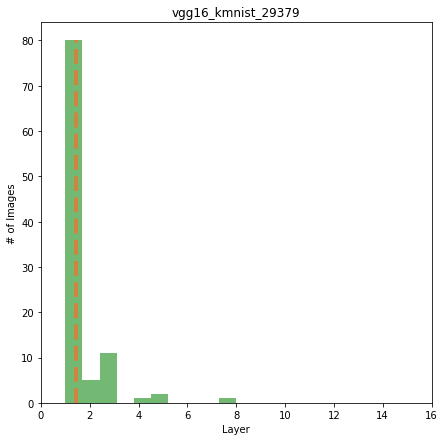

In [24]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
# plt.ylim((0,80))
plt.hist(batch_info['pd'],bins=10,color='g',alpha=0.55)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
pd_mean = np.mean(batch_info['pd'])
plt.vlines(pd_mean,0,80,color='peru',linestyle='dashed',linewidth=4)
# plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [25]:
os.path.join(save_dir,expt_name+'_testPDinfo.pkl')

'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/output/vgg16_kmnist_29379_testPDinfo.pkl'

In [26]:
expt_name+'_testPDinfo.pkl'

'vgg16_kmnist_29379_testPDinfo.pkl'

# Visualize using SHAP

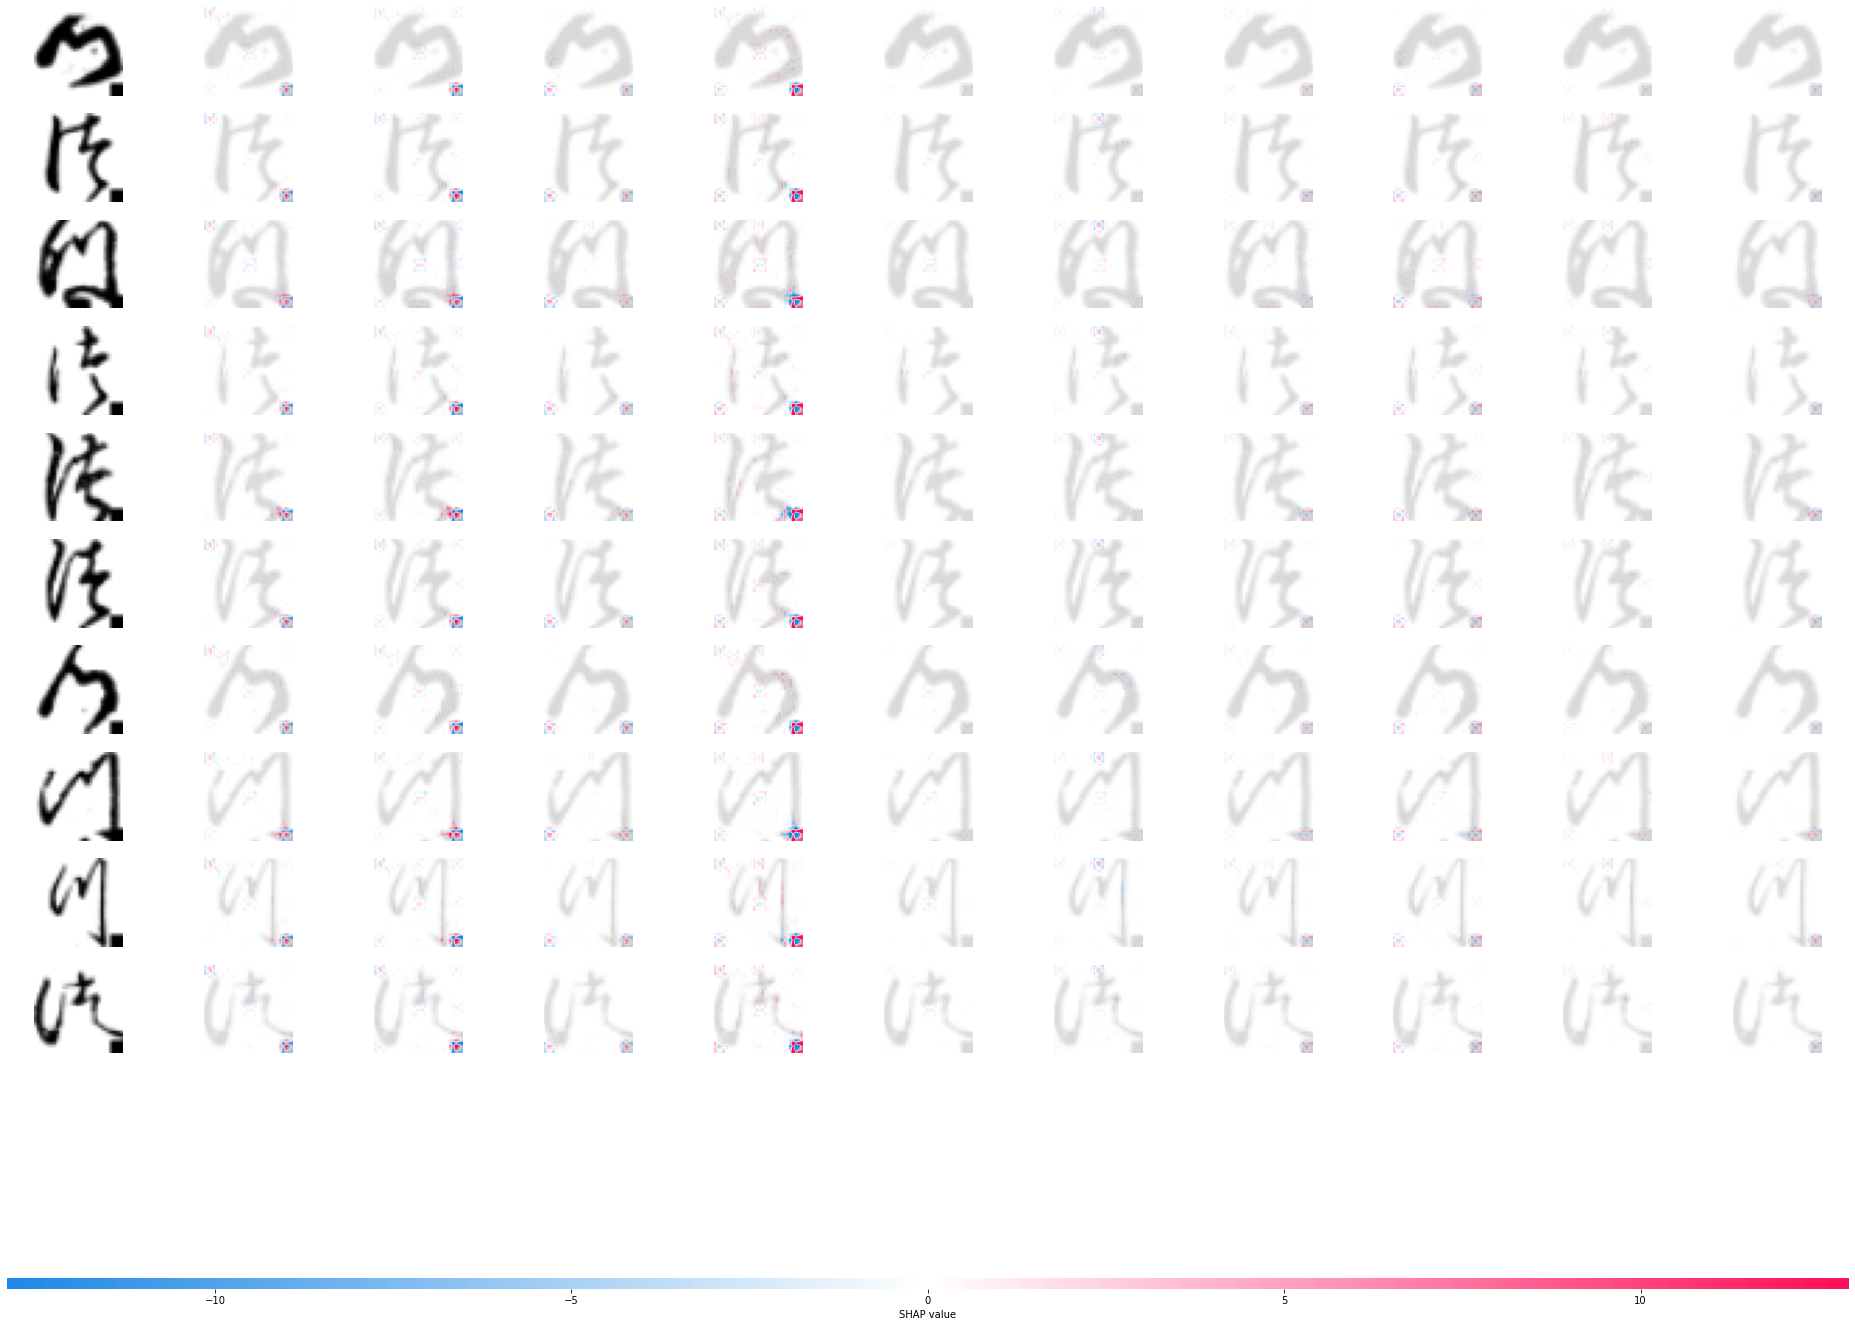

In [30]:
# shap on final layer output
# rows represent different image, columns represent the 10 different classes, and the corresponding features that highlight that class
net.eval()

batch = next(iter(testloader))
shap_train_imgs = batch[0][:10].to('cuda')
shap_test_imgs = batch[0][batch[1]==3][10:20].to('cuda') # choose the subset of images you're interested in

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(shap_test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)
# plt.savefig('./shap_test.pdf') # add show=False argument to the shap.image_plot fn to save this plot